In [33]:
axis_pair8,axis_pair6,axis_pair4,axis_pair0 = [],[],[],[]
area8,area6,area4,area0 =  [],[],[],[]
maxMPS_list, centroidMPS_list,centroid_Brain = [], [],[]
vec1_list, vec2_list = [], []
volume = []

In [60]:
import NewCore
import os
os.chdir('/Volumes/FAIR/DC-Image-Analysis/DC-project-master/cleancode/NewMidplane')
import Functions
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import rotate
%matplotlib inline


from scipy.ndimage.morphology import binary_opening as bo
from scipy.ndimage.morphology import binary_erosion as be
from scipy.ndimage.morphology import binary_closing as bc
from scipy.ndimage.morphology import binary_fill_holes as bfh

import skimage
from skimage import filters

 
def BiggestRegion(array):
    labels,num = skimage.measure.label(array, connectivity=3,return_num='Ture')
    if num>1:
        props = skimage.measure.regionprops(labels)
        b = [p.area for p in props]
        ind = b.index(max(b))
        bcoords = props[ind].coords
        b_loop = np.zeros((array.shape))
        for i in range(len(bcoords)):
                a,b,c = bcoords[i]
                b_loop[a,b,c]=1
    else:
        b_loop = array
        
    return b_loop

from ipywidgets import interact, fixed
from IPython.display import display

def wl_to_lh(window, level):
    low = level - window/2
    high = level + window/2
    return low,high

import skimage
from skimage import filters

def display_image(img, x=None, y=None, z=None, window=None, level=None):
    # Convert SimpleITK image to NumPy array
    img_array = sitk.GetArrayFromImage(img)
    
    # Get image dimensions in millimetres
    size = img.GetSize()
    spacing = img.GetSpacing()
    width  = size[0] * spacing[0]
    height = size[1] * spacing[1]
    depth  = size[2] * spacing[2]
    
    if x is None:
        x = np.floor(size[0]/2).astype(int)
    if y is None:
        y = np.floor(size[1]/2).astype(int)
    if z is None:
        z = np.floor(size[2]/2).astype(int)
    
    if window is None:
        window = np.max(img_array) - np.min(img_array)
    
    if level is None:
        level = window / 2 + np.min(img_array)
    
    low,high = wl_to_lh(window,level)

    # Display the orthogonal slices
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    ax1.imshow(img_array[z,:,:], cmap='gray', clim=(low, high), extent=(0, width, height, 0))
    ax2.imshow(img_array[:,y,:], origin='lower', cmap='gray', clim=(low, high), extent=(0, width,  0, depth))
    ax3.imshow(img_array[:,:,x], origin='lower', cmap='gray', clim=(low, high), extent=(0, height, 0, depth))

    # Additionally display crosshairs
    ax1.axhline(y * spacing[1], lw=1)
    ax1.axvline(x * spacing[0], lw=1)
    
    ax2.axhline(z * spacing[2], lw=1)
    ax2.axvline(x * spacing[0], lw=1)
    
    ax3.axhline(z * spacing[2], lw=1)
    ax3.axvline(y * spacing[1], lw=1)

    plt.show()
    
def reshape(array, ConstPixelSpacing):
    """ Reshape array to have cubic voxels of size 1mm^3 """
    '''mind the a, b, c value is adjusted to make each '''

    width = array.shape[0]
    height = array.shape[1]
    depth = array.shape[2]
    a = int((width)*ConstPixelSpacing[0])
    b = int((height)*ConstPixelSpacing[1])
    c = int((depth)*ConstPixelSpacing[2])
    reshapedArray1 = np.zeros((a,height,depth))
    xp = np.linspace(0, (width-1)*ConstPixelSpacing[0], width) #adjust xp as [0,1ConstPixelSpacing,2CPS..
    x  = np.linspace(0, a-1, a)

    for j in range(height):
        for k in range(depth):
            reshapedArray1[:,j,k] = np.interp(x, xp, array[:,j,k])
    reshapedArray2 = np.zeros((a,b,depth))
    yp = np.linspace(0,(height-1)*ConstPixelSpacing[1],height)
    y = np.linspace(0,b-1,b)
    for j in range(a):
        for k in range(depth):
            reshapedArray2[j,:,k] = np.interp(y, yp, reshapedArray1[j,:,k])
    reshapedArray3 = np.zeros((a,b,c))
    zp = np.linspace(0,(depth-1)*ConstPixelSpacing[2],depth)
    z = np.linspace(0,c-1,c)
    for j in range(a):
        for k in range(b):
            reshapedArray3[j,k,:] = np.interp(z, zp, reshapedArray2[j,k,:])
    return reshapedArray3
    


def saveImage(array,img):
    array = np.swapaxes(array,0,2)
    mask = sitk.GetImageFromArray(array)
    mask.CopyInformation(img)
    sitk.WriteImage(mask, os.path.split(path)[0] + '/ROI.nii.gz')


In [61]:
paths = ['/Volumes/FAIR/Registered_MPS3/MPS1',
         '/Volumes/FAIR/Registered_MPS3/MPS2',
         '/Volumes/FAIR/Registered_MPS3/MPS3',
         '/Volumes/FAIR/Registered_MPS3/MPS4',
         '/Volumes/FAIR/Registered_MPS3/MPS5',
         '/Volumes/FAIR/Registered_MPS3/MPS6',
         '/Volumes/FAIR/Registered_MPS3/MPS7',
         '/Volumes/FAIR/Registered_MPS3/MPS8',
         '/Volumes/FAIR/Registered_MPS3/MPS9',
         '/Volumes/FAIR/Registered_MPS3/MPS10',
         '/Volumes/FAIR/Registered_MPS3/MPS11',
         '/Volumes/FAIR/Registered_MPS3/MPS12',
         '/Volumes/FAIR/Registered_MPS3/MPS13',
         '/Volumes/FAIR/Registered_MPS3/MPS14',
         '/Volumes/FAIR/Registered_MPS3/SDH4',
         '/Volumes/FAIR/Registered_MPS3/SDH7',
         '/Volumes/FAIR/Registered_MPS3/SDH8',
         '/Volumes/FAIR/Registered_MPS3/SDH11',
         '/Volumes/FAIR/Registered_MPS3/SDH12',
         '/Volumes/FAIR/Registered_MPS3/SDH14',
         '/Volumes/FAIR/Registered_MPS3/SDH16-2',
         '/Volumes/FAIR/Registered_MPS3/SDH24',
         '/Volumes/FAIR/Registered_MPS3/CONT5',
         '/Volumes/FAIR/Registered_MPS3/CONT7',
         '/Volumes/FAIR/Registered_MPS3/EDH7',
         '/Volumes/FAIR/Registered_MPS3/Sample3_Pre',
         '/Volumes/FAIR/Registered_MPS3/Sample3_Post',
         '/Volumes/FAIR/Registered_MPS3/Sample4_Pre',
         '/Volumes/FAIR/Registered_MPS3/tutorial3',
         '/Volumes/FAIR/Registered_MPS3/ScanD',
         '/Volumes/FAIR/Registered_MPS3/ScanE',
         '/Volumes/FAIR/Registered_MPS3/ScanF',
         '/Volumes/FAIR/Registered_MPS3/ScanH',
        ]

m = 0
path = paths[m]
print( "Reading directory:", path)

mask = sitk.ReadImage(path + '/lesion.nii.gz')
Mask_array = sitk.GetArrayFromImage(mask)
Mask_array = np.swapaxes(Mask_array,0,2)
ConstPixelSpacing = mask.GetSpacing()

Reading directory: /Volumes/FAIR/Registered_MPS3/MPS1


In [62]:
Lesion_array = np.zeros(Mask_array.shape)
# Lesion_array[Mask_array==19] = 1
Lesion_array[Mask_array==1] = 1

Mask_array = Lesion_array
np.nonzero(Mask_array)

(array([175, 176, 177, ..., 314, 314, 314]),
 array([ 85,  85,  85, ..., 264, 265, 266]),
 array([33, 33, 32, ..., 31, 31, 31]))

In [63]:
mp = sitk.ReadImage(path + '/MPS.nii.gz')
mp_array = sitk.GetArrayFromImage(mp)
mp_array = np.swapaxes(mp_array,0,2)
ConstPixelSpacing = mp.GetSpacing()

ml = sitk.ReadImage(path + '/Midplane_Q.nii.gz')
ml_array = sitk.GetArrayFromImage(ml)
ml_array = np.swapaxes(ml_array,0,2)

sku = sitk.ReadImage(path + '/Skull_contour.nii.gz')
sku_array = sitk.GetArrayFromImage(sku)
sku_array = np.swapaxes(sku_array,0,2)

if ConstPixelSpacing != (1,1,1):
    Reshaped_mp = reshape(mp_array,ConstPixelSpacing)
    Reshaped_ml = reshape(ml_array,ConstPixelSpacing)
    Reshaped_sku = reshape(sku_array,ConstPixelSpacing)
    Reshaped_lesion = reshape(Lesion_array,ConstPixelSpacing)


else:
    Reshaped_mp = mp_array
    Reshaped_ml = ml_array
    Reshaped_sku = sku_array
    Reshaped_lesion = Lesion_array

#Import ideal midplane parameters
paras = np.load("/Volumes/FAIR/Registered_MPS3/MPS_para2.npy",encoding= 'bytes')


# img_gauss = sitk.DiscreteGaussian(img, variance=1)
# display_image(img_gauss,window=120, level=40)

# paras = np.load('/Volumes/FAIR/DC-Image-Analysis/DC-project-master/cleancode/NewMidplane/Final_preop.npy')
file, a, b, c, d = paras[m]
a, b, c, d = a.astype(float),b.astype(float),c.astype(float),d.astype(float)
v = np.array((a,b,c))
v = v.astype(float)
print(file, a, b, c, d, path)

# midplane normal vector regulate the direction
if a<0:
    a,b,c,d = a*-1,b*-1,c*-1,d*-1
n = np.array((a,b,c))

#define rotation axis in plane, in z direction correlates to skew angle
from sympy import *
import sympy
x = sympy.symbols('x')
x1 = solve(a*x + b*100 + c*0 - d, x)
x2 = solve(a*x + b*100 + c*100 - d, x)
k = np.array((x1[0]-x2[0],0,-100)).astype(float)
# k = k/np.sqrt((k[0]**2 + k[1]**2 + k[2]**2))
vk_unit = Functions.unit_vector(k)
vk_unit

## Define rotation axis in y direction, correlating to the orientation angle
x = sympy.symbols('x')
x3 = solve(a*x + b*0.0 + c*100.0- d, x)
x4 = solve(a*x + b*100.0 + c*100.0 - d, x)

k2 = np.array((x3[0]-x4[0],-100.0,0.0)).astype(float)
vk2_unit = Functions.unit_vector(k2)
# the new_vk corresponds to the reshaped version of array, as displayed in ITK
# new_vk = Functions.unit_vector(vk_unit*ConstPixelSpacing)
vk2_unit

#the orientation angle
yaxis = np.array((0,1,0))
angle_ori = Functions.ang(vk2_unit,yaxis)
zaxis = np.array((0,0,1))
# angle_skew = Functions.ang(new_vk,zaxis)
angle_skew = Functions.ang(vk_unit,zaxis)

# Convert to degrees
# The skew angle 
A_S = 180.0 - angle_skew/np.pi*180.0
# The orientation angle
A_O = 180.0 - angle_ori/np.pi*180.0

if vk2_unit[0]*vk2_unit[1] < 0.0:
    A_O = -1*A_O
    
if vk_unit[0]*vk_unit[2] < 0.0:
    A_S = -1*A_S
    
# Calculate the x-coordinate of the miplane, should be a uniform value

# Constant mode rotation, points outside the boundaries of the input 
# are filled with constant 0.0. If points

# ML_array = array
# ideal midplane
Ideal_ML = np.multiply(Reshaped_ml >0.2, Reshaped_ml)
# mask = active_mask

from scipy.ndimage.interpolation import rotate
r_ml = rotate(Ideal_ML,A_O,mode='constant',axes=(0,1))
r2_ml = rotate(r_ml,A_S,mode='constant',axes=(0,2))

r_mp = rotate(Reshaped_mp,A_O,mode='constant',axes=(0,1))
r2_mp = rotate(r_mp,A_S,mode='constant',axes=(0,2))

binary_mp = np.multiply(r2_mp,r2_mp > 0.1)

r_sku = rotate(Reshaped_sku,A_O,mode='constant',axes=(0,1))
r2_sku = rotate(r_sku,A_S,mode='constant',axes=(0,2))

r_lesion = rotate(Reshaped_lesion,A_O,mode='constant',axes=(0,1))
r2_lesion = rotate(r_lesion,A_S,mode='constant',axes=(0,2))

b'MPS1' 0.999900729343 0.0122390140491 0.00698126029796 118.490456219 /Volumes/FAIR/Registered_MPS3/MPS1


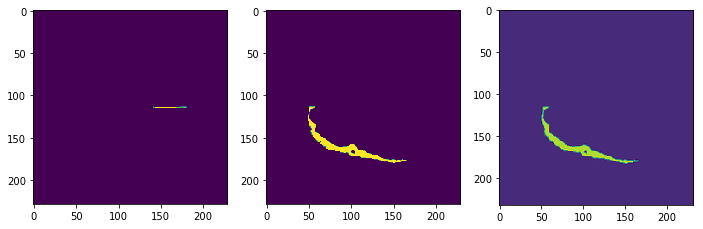

In [64]:
i1 = 30
i2 = int((float(i1)/sku_array.shape[2])*r2_sku.shape[2])

plt.figure(figsize=(16,5))
plt.subplot(141)
plt.imshow(Reshaped_mp[:,:,i1])

plt.subplot(142)
plt.imshow(Reshaped_lesion[:,:,i2])

plt.subplot(143)
plt.imshow(r2_lesion[:,:,i2])
plt.show()

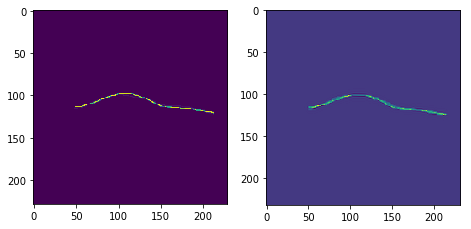

In [65]:
i = 105

plt.figure(figsize=(16,5))
plt.subplot(141)

# plt.imshow(mask[:,i,:]
plt.imshow(Reshaped_mp[:,:,i])
plt.subplot(142)
plt.imshow(r2_mp[:,:,i])
plt.show()

In [66]:
# When finding the binary mask, try to look somewhere around the average value
# make sure Binary_mask is not too coarse than the original mask
r2_mp.mean()

0.0017649766903053081

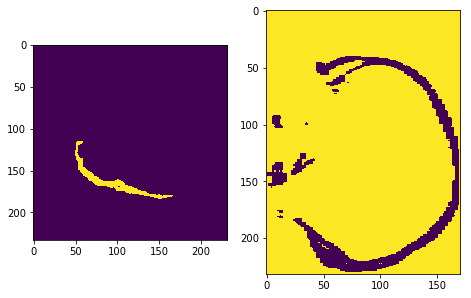

In [67]:
Binary_Mask = np.zeros(r2_mp.shape)
Binary_Mask[np.abs(r2_lesion)>0.2]=1

Binary_sku  = np.zeros(r2_sku.shape)
Binary_sku[np.abs(r2_sku)>0.1] = -1

# Check the spread range of x1 value should be very small
# Calculate the reference_x coordinates
Binary_mp = np.zeros(r2_ml.shape)
Binary_mp[np.abs(r2_ml)>0.4]=1
r2_IMLq = Binary_mp
xr = np.nonzero(r2_IMLq)[0]
counts = np.bincount(xr)
reference_x = np.argmax(counts)

Skull_Contour = Binary_sku[reference_x,:,:]


plt.figure(figsize=(16,5))
plt.subplot(141)
plt.imshow(Binary_Mask[:,:,i2])

plt.subplot(142)
plt.imshow(Binary_sku[reference_x,:,:])

In [68]:
midplane_split = np.zeros(r2_mp.shape)
for i in range(reference_x-1,r2_mp.shape[0]):
    midplane_split[i,:,:] = 1

Left_mask = np.multiply(Binary_Mask,midplane_split==0)
Right_mask = np.multiply(Binary_Mask,midplane_split==1)

Left_sum = np.sum(Left_mask,0)
Right_sum = np.sum(Right_mask,0)
H_diff = Left_sum-Right_sum

y,z = np.nonzero(H_diff)
lesion_contour = Skull_Contour.copy()
pure_lesion = np.ones(Skull_Contour.shape) * 1000

for i in range(len(z)):
#     Skull_Contour[z[i]-1,y[i]-1]= H_diff[z[i]-1,y[i]-1]
    lesion_contour[y[i]-1,z[i]-1]= H_diff[y[i]-1,z[i]-1]
    pure_lesion[y[i]-1,z[i]-1]= H_diff[y[i]-1,z[i]-1]

pure_lesion[pure_lesion==1000]=np.nan

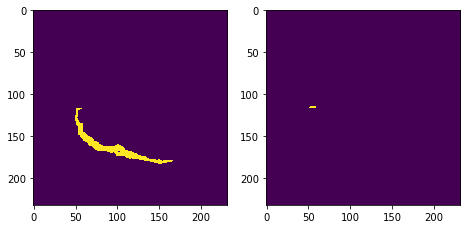

In [69]:
# View the rotation from axial plane


plt.figure(figsize=(16,5))
plt.subplot(141)
plt.imshow(Right_mask[:,:,i2])
plt.subplot(142)
plt.imshow(Left_mask[:,:,i2])


plt.show()

<IPython.core.display.Javascript object>


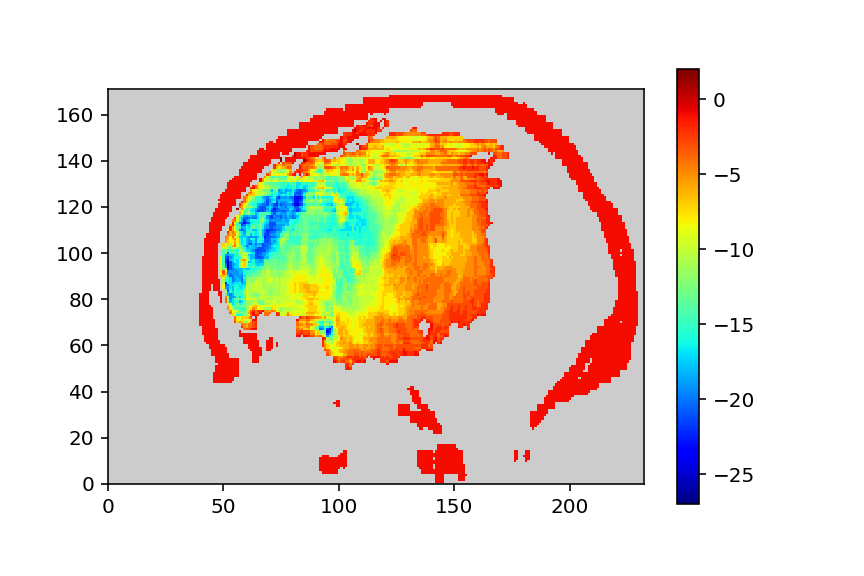

In [70]:
%matplotlib nbagg
fig, ax = plt.subplots()
lesion_contour[lesion_contour==0]=np.nan
palette = plt.cm.jet
palette.set_bad(alpha=0.2)
# heatmap = ax.imshow(pure_lesion.transpose(), cmap=palette)
heatmap = ax.imshow(lesion_contour.transpose(), cmap=palette)
# heatmap = ax.pcolor(brain_diff==0, cmap=plt.cm.winter)
plt.ylim(0, Skull_Contour.shape[1])
plt.xlim (0,Skull_Contour.shape[0])
# ax.set_aspect(ConstPixelSpacing[2]/ConstPixelSpacing[1])
plt.colorbar(heatmap)
plt.show()

os.chdir(path)
plt.savefig('lesion_contour.png')

# Lesion parameters

In [71]:
L_coor = np.where(Binary_Mask>0)
L_centroid = np.mean(L_coor,1)
L_centroid,reference_x

(array([ 157.28850097,   99.27436003,  106.29147677]), 118)

<IPython.core.display.Javascript object>


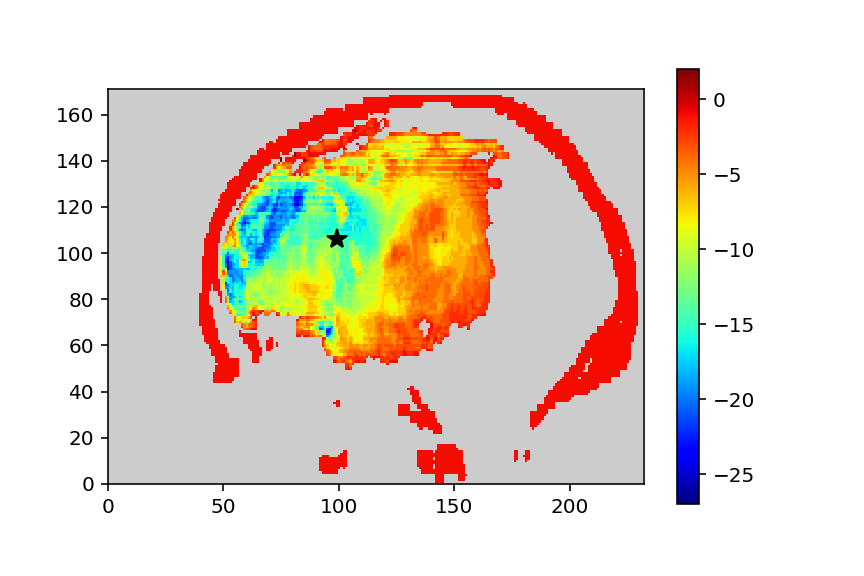

In [72]:
%matplotlib nbagg
fig, ax = plt.subplots()
lesion_contour[lesion_contour==0]=np.nan
palette = plt.cm.jet
palette.set_bad(alpha=0.2)
# heatmap = ax.imshow(pure_lesion.transpose(), cmap=palette)
heatmap = ax.imshow(lesion_contour.transpose(), cmap=palette)
# heatmap = ax.pcolor(brain_diff==0, cmap=plt.cm.winter)
plt.plot([L_centroid[1]], [L_centroid[2]], marker='*', markersize=10, color="black")

plt.ylim(0, Skull_Contour.shape[1])
plt.xlim (0,Skull_Contour.shape[0])
# ax.set_aspect(ConstPixelSpacing[2]/ConstPixelSpacing[1])
plt.colorbar(heatmap)
plt.show()

os.chdir(path)
plt.savefig('lesion_contour.png')


In [73]:
# ID = []
# Lesion_centroids = []
# reference_x_list = []
# volume = []

volume_lesion = np.sum(Binary_Mask)

ID.append(file)
Lesion_centroids.append(L_centroid)
reference_x_list.append(reference_x)
volume.append(volume_lesion)

In [74]:
output = {'ID': ID, 'Lesion_centroids': Lesion_centroids,'reference_x%':reference_x_list, 
          'lesion_volume':volume,
         }
output

{'ID': [b'MPS1', b'MPS1', b'MPS1'],
 'Lesion_centroids': [array([ 157.28850097,   99.27436003,  106.29147677]),
  array([ 157.28850097,   99.27436003,  106.29147677]),
  array([ 157.28850097,   99.27436003,  106.29147677])],
 'lesion_volume': [60699.873333333329, 85355.0],
 'reference_x%': [118, 118, 118]}

In [353]:
import pandas as pd
lesion_metrics = pd.DataFrame(data=output)
lesion_metrics.to_csv('lesion_metrics1.csv')

# Lesion centroids
To do the lesion vector map, arrows pointing from centriod of lesion to centroid of midplane shift. 

Cannot use the absolute location of the lesion and the centroids because the registration is not perfect

Instead, all coordinates has to be all adjusted with respect to the centroids of the current skull sihoullet.

In [395]:
lesion_metrics = pd.read_csv('/Volumes/FAIR/Registered_MPS/lesion_metrics.csv',index_col=0)

In [414]:
# Drop SDH8 because of it's less satisfactory registration performance
lesion_metrics = lesion_metrics.drop(lesion_metrics.index[3])

In [415]:
#Centriods of current skull contour
C_brain_y = lesion_metrics['centroid_Brain_coord_y'][-1]
C_brain_z = lesion_metrics['centroid_Brain_coord_z'][-1]

In [416]:
lesion_metrics


,Lesion_centroids_y,Lesion_centroids_z,Lesion_centroids_x,reference_x%,centroidMPS_coord_y,centroidMPS_coord_z,centroid_Brain_coord_y,centroid_Brain_coord_z,Unnamed: 9,l1,l2,m1,m2
ID,,,,,,,,,,,,,
b'SDH2',58.952584,80.779654,82.658296,100,74.659278,76.560530,107.753605,64.226921,NaN,-48.801022,16.552733,-33.094328,12.333609
b'SDH4',73.044927,79.072341,58.035473,97,85.784236,73.334126,107.492329,68.727608,NaN,-34.447401,10.344733,-21.708093,4.606518
b'SDH7',125.365814,128.489698,110.020973,152,125.342864,119.415000,146.478011,118.304206,NaN,-21.112197,10.185492,-21.135146,1.110794
b'SDH9',120.105008,74.401137,184.088901,130,107.563947,90.200665,132.919119,84.402012,NaN,-12.814111,-10.000874,-25.355173,5.798653
b'SDH11',90.201207,88.137822,91.561589,134,113.224698,95.266760,137.119977,87.499095,NaN,-46.918769,0.638727,-23.895279,7.767665
b'SDH12',150.587053,79.439780,178.429950,133,124.436668,81.566261,140.039703,80.294498,NaN,10.547350,-0.854718,-15.603035,1.271763
b'SDH14',123.200535,104.506962,144.323129,110,128.762468,92.835752,102.460450,92.095434,NaN,-20.740085,12.411528,-26.302018,0.740318
b'SDH16-2',152.144434,83.840551,166.155492,129,125.058102,82.611198,143.535066,77.400217,NaN,8.609368,6.440334,-18.476965,5.210981
b'SDH24',123.074333,77.276141,78.671151,125,123.089712,71.425691,139.588910,76.357307,NaN,-16.514577,0.918834,-16.499197,-4.931615


<IPython.core.display.Javascript object>


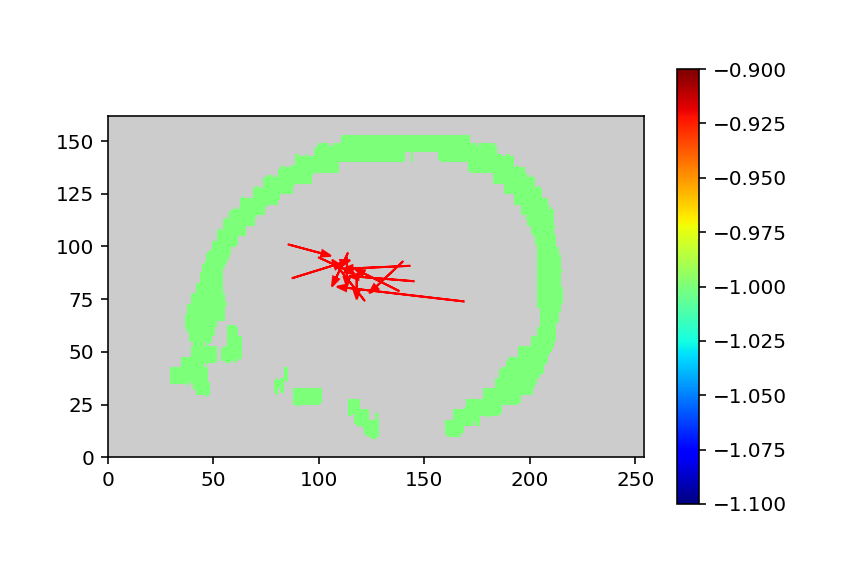

In [419]:
%matplotlib nbagg
fig, ax = plt.subplots()
palette = plt.cm.jet
palette.set_bad(alpha=0.2)
Skull_Contour[Skull_Contour==0]= np.nan
heatmap = ax.imshow(Skull_Contour.transpose(), cmap=palette)
# matplotlib.pyplot.arrow(x, y, dx, dy,head_width=4)
# matplotlib.pyplot.arrow(x, y, dx, dy,head_width=4)

for i in range(len(lesion_metrics)):
# for i in range(0,1):
    l_y = C_brain_y + lesion_metrics['l1'][i]
    l_z = C_brain_z + lesion_metrics['l2'][i] 
    mps_y = C_brain_y + lesion_metrics['m1'][i] 
    mps_z = C_brain_z + lesion_metrics['m2'][i] 
    dy = mps_y - l_y
    dz = mps_z - l_z
    matplotlib.pyplot.arrow(l_y,l_z,dy,dz,head_width=3,color = 'red')
#     plt.plot(mps_y, mps_z, marker='o', markersize=4, color="blue")
#     plt.plot(l_y, l_z, marker='o', markersize=4, color="red")


# white towards centroid of MPS deviation
# green towards max MPS point
# matplotlib.pyplot.arrow(x, y, wx, wy,head_width=5,color = 'green')


# plt.plot([x], [y], marker='o', markersize=4, color="red")

# heatmap = ax.imshow(lesion_contour.transpose(), cmap=palette)
# heatmap = ax.pcolor(brain_diff==0, cmap=plt.cm.winter)
plt.ylim(0, Skull_Contour.shape[1])
plt.xlim (0,Skull_Contour.shape[0])
# ax.set_aspect(ConstPixelSpacing[2]/ConstPixelSpacing[1])
plt.colorbar(heatmap)
# plt.title('centroid of mps and lesion')
plt.show()
# plt.ion()

## MPS using rotation of the mps

number of MPS points: 232
Midplane shift to the left hemisphere
Average MPS length: nan 
Max MPS deviation: 18.5 
MPS_volume: 60859.1466667


/anaconda/envs/mic3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater
/anaconda/envs/mic3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in less
/anaconda/envs/mic3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less


<IPython.core.display.Javascript object>


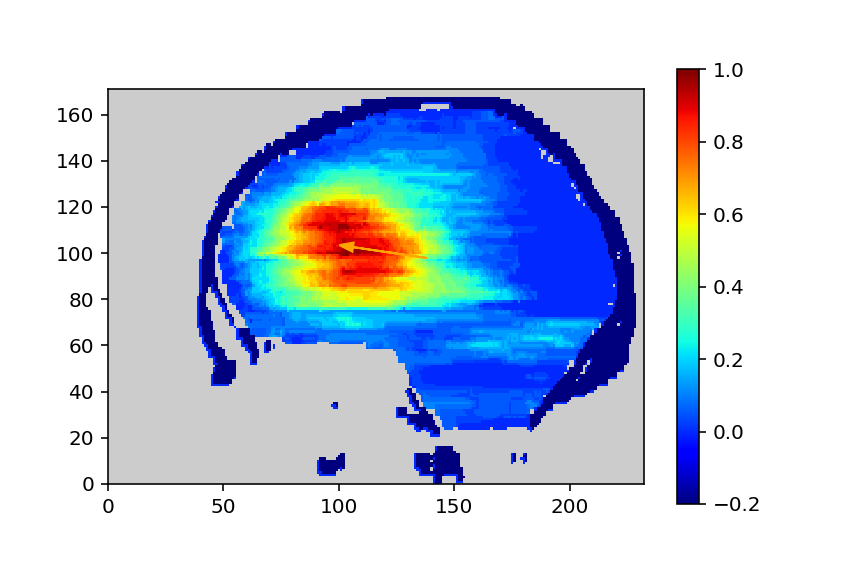

In [75]:
Binary_mps = np.zeros(r2_mp.shape)
Binary_mps[np.abs(r2_mp)>0.1]=1
print('number of MPS points:',len(Binary_mps[0]))

dis = np.nonzero(Binary_mps)
MPS_metrix = np.ones(Binary_mps.shape[:2]) * 100
MPS_metrix_normalized = np.zeros(Binary_mps.shape[:2])

# max_dev = float(np.max(np.abs(dis[0]-reference_x)))

coord_list = []
dic = {}
for i in range(len(dis[0])):
    if (dis[1][i],dis[2][i]) in coord_list:
        dic[(dis[1][i],dis[2][i])].append((dis[0][i]))
    else:
        coord_list.append((dis[1][i],dis[2][i]))
        dic[(dis[1][i],dis[2][i])] = [dis[0][i]]

# in dis, there might be overlapping coordinates in MPS plane due to the rotation effects
# get the mean value of those overlapping keys

for i in coord_list:
    MPS_metrix[i] = np.mean(dic[i]) - reference_x
    
MPS_metrix[MPS_metrix==100.] = np.nan
# Deviation to the right is positive!
# if np.sum(MPS_metrix>0) > np.sum(MPS_metrix<0):
if np.sum(MPS_metrix[MPS_metrix>0]) > np.sum(np.abs(MPS_metrix[MPS_metrix<0])):
    print('inaccuracy:', np.min(MPS_metrix))
    MPS_metrix[MPS_metrix < 0] = 0.01
    print("Midplane shift to the right hemisphere")
else:
    MPS_metrix = MPS_metrix * -1
    MPS_metrix[MPS_metrix < 0] = 0.01
    print("Midplane shift to the left hemisphere")
    
MPS_metrix_normalized = MPS_metrix/np.nanmax(MPS_metrix)
print('Average MPS length:', np.mean(MPS_metrix),'\n'
     'Max MPS deviation:', np.nanmax(MPS_metrix),'\n'
     'MPS_volume:', np.nansum(MPS_metrix)
     )

# MPS_metrix[MPS_metrix==0.] = np.nan
# MPS_metrix_normalized[MPS_metrix_normalized==0.] = np.nan

import scipy
# ww[ww==0] = np.nan
ww = scipy.ndimage.filters.gaussian_filter(MPS_metrix_normalized,1)
# ww[ww==0] = np.nan

Skull_Contour[np.nonzero(Skull_Contour)] = -0.2
mps_contour = MPS_metrix_normalized.copy()
y,z = np.nonzero(Skull_Contour)
for i in range(len(z)):
    mps_contour[y[i]-1,z[i]-1]= Skull_Contour[y[i]-1,z[i]-1]

%matplotlib nbagg
fig, ax = plt.subplots()
# lesion_contour[lesion_contour==0]=np.nan
palette = plt.cm.jet
palette.set_bad(alpha=0.2)
heatmap = ax.imshow(mps_contour.transpose(), cmap=palette)
# heatmap = ax.imshow(ww.transpose(), cmap=palette)
# heatmap = ax.imshow(MPS_metrix_normalized.transpose())

plt.ylim(0, Skull_Contour.shape[1])
plt.xlim (0,Skull_Contour.shape[0])
# ax.set_aspect(ConstPixelSpacing[2]/ConstPixelSpacing[1])
plt.colorbar(heatmap)
plt.show()

os.chdir(path)
plt.savefig('mps_contour.png')

In [76]:
from skimage import filters
import scipy.ndimage as ndi
from skimage.segmentation import find_boundaries as boundaries
import skimage

def region_parameter(region):
    #     Output the region parameters including centroid coordinate, 
    #     region area, length of major and minor axis
    labels = skimage.measure.label(region, connectivity=1)
    props = skimage.measure.regionprops(labels)
    v = [p.area for p in props]
    ind = np.argsort(v)
    # # From first to fourth biggest region
    #   determine whether the regions are connected or not
    n_regions = len(v)
    vcoords = props[ind[-1]].coords
    Area = v[ind[-1]]
    V_centroid = props[ind[-1]].centroid

    # The length of the major axis of the ellipse that has the same 
    # normalized second central moments as the region
    axis_major = props[ind[-1]].major_axis_length
    axis_minor = props[ind[-1]].minor_axis_length
    return n_regions,Area,V_centroid,axis_major,axis_minor

def average(xs):
    N = float(len(xs))
    return tuple(sum(col)/N for col in zip(*xs))

MPS = MPS_metrix_normalized
# Region of relative MPS greater than 0.6
region06 = np.zeros(MPS.shape)
region06[MPS>0.6] = 1

# Region of relative MPS greater than 0
region0 = np.zeros(MPS.shape)
region0[MPS>0] = 1

# Region of relative MPS greater than 0.8
region08 = np.zeros(MPS.shape)
region08[MPS>0.8] = 1

# Region of relative MPS greater than 0.8
region04 = np.zeros(MPS.shape)
region04[MPS>0.4] = 1

n,Area0,Centroid0,axis_major0,axis_minor0 = region_parameter(region0)
n,Area4,Centroid4,axis_major4,axis_minor4 = region_parameter(region04)
n,Area6,Centroid6,axis_major6,axis_minor6 = region_parameter(region06)
n,Area8,Centroid8,axis_major8,axis_minor8 = region_parameter(region08)

maxMPS = np.where(ww==np.nanmax(ww))[0][0],np.where(ww==np.nanmax(ww))[1][0]



# Vectors pointing from centroid of brain to centroid of cross plane deviation
mps_centroid = average([Centroid4,Centroid6,Centroid8])

vec1 = np.subtract(mps_centroid,Centroid0)
# vec1 pointing tawards the centroid of midplane deviation
vec2 = np.subtract(maxMPS,Centroid0)
# vec2 pointing towards the max MPS deviation point


import matplotlib
x,y = Centroid0
dx,dy = vec1
wx,wy = vec2

matplotlib.pyplot.arrow(x, y, dx, dy,head_width=4,color = 'orange')


# Specify vec1 or vec2

/anaconda/envs/mic3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater
/anaconda/envs/mic3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/anaconda/envs/mic3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater
/anaconda/envs/mic3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in greater


<IPython.core.display.Javascript object>


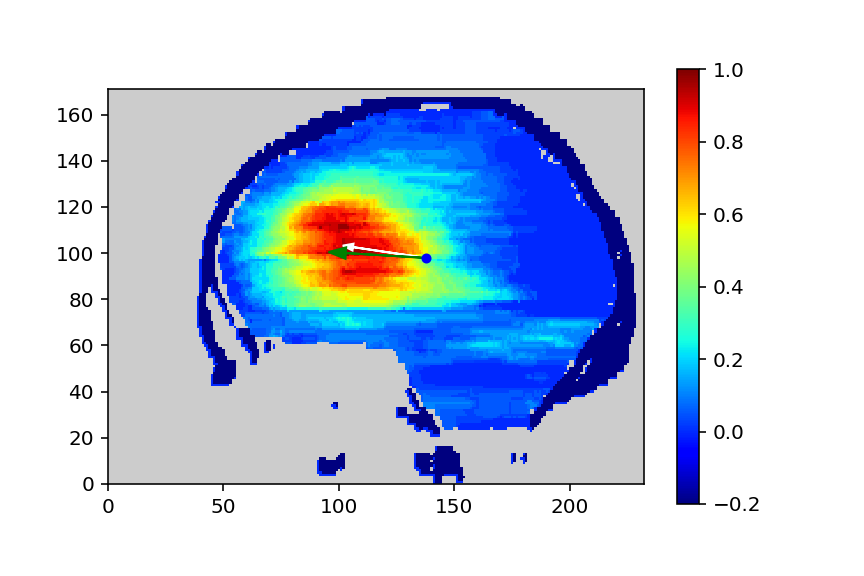

In [77]:
%matplotlib nbagg
fig, ax = plt.subplots()
palette = plt.cm.jet
palette.set_bad(alpha=0.2)
Skull_Contour[Skull_Contour==0]= np.nan
heatmap = ax.imshow(mps_contour.transpose(), cmap=palette)
# matplotlib.pyplot.arrow(x, y, dx, dy,head_width=4)
# matplotlib.pyplot.arrow(x, y, dx, dy,head_width=4)

matplotlib.pyplot.arrow(x, y, dx, dy,head_width=3,color = 'white')
# white towards centroid of MPS deviation
# green towards max MPS point
matplotlib.pyplot.arrow(x, y, wx, wy,head_width=5,color = 'green')


plt.plot([x], [y], marker='o', markersize=4, color="blue")

# heatmap = ax.imshow(lesion_contour.transpose(), cmap=palette)
# heatmap = ax.pcolor(brain_diff==0, cmap=plt.cm.winter)
plt.ylim(0, Skull_Contour.shape[1])
plt.xlim (0,Skull_Contour.shape[0])
# ax.set_aspect(ConstPixelSpacing[2]/ConstPixelSpacing[1])
plt.colorbar(heatmap)
plt.show()
os.chdir(path)
plt.savefig('mps_vecs.png')

In [78]:
# coord_list = []
# dic = {}
# for i in range(len(dis[0])):
#     if (dis[1][i],dis[2][i]) in coord_list:
#         dic[(dis[1][i],dis[2][i])].append((dis[0][i]))
#     else:
#         coord_list.append((dis[1][i],dis[2][i]))
#         dic[(dis[1][i],dis[2][i])] = [dis[0][i]]

# # in dis, there might be overlapping coordinates in MPS plane due to the rotation effects
# # get the mean value of those overlapping keys

# for i in coord_list:
   
#     MPS_metrix[i] = np.mean(dic[i]) - reference_x


Binary_mps = np.zeros(r2_mps.shape)
Binary_mps[np.abs(r2_mps)>0.03]=1
print('number of MPS points:',len(Binary_mps[0]))

dis = np.nonzero(Binary_mps)
MPS_metrix = np.zeros(Binary_mps.shape[:2])
MPS_metrix_normalized = np.zeros(Binary_mps.shape[:2])

# max_dev = float(np.max(np.abs(dis[0]-reference_x)))

coord_list = []
dic = {}
for i in range(len(dis[0])):
    if (dis[1][i],dis[2][i]) in coord_list:
        dic[(dis[1][i],dis[2][i])].append((dis[0][i]))
    else:
        coord_list.append((dis[1][i],dis[2][i]))
        dic[(dis[1][i],dis[2][i])] = [dis[0][i]]

# in dis, there might be overlapping coordinates in MPS plane due to the rotation effects
# get the mean value of those overlapping keys

for i in coord_list:
    MPS_metrix[i] = np.mean(dic[i]) - reference_x

NameError: name 'r2_mps' is not defined

In [18]:
np.sum(MPS_metrix[MPS_metrix>0]),np.sum(MPS_metrix[MPS_metrix<0])

(100.91666666666664, -46743.155952380948)

In [19]:
np.sum(MPS_metrix>0),np.sum(MPS_metrix<0)

(195, 16908)

In [20]:
# Deviation to the right is positive!
# if np.sum(MPS_metrix>0) > np.sum(MPS_metrix<0):
if np.sum(MPS_metrix[MPS_metrix>0]) > np.sum(np.abs(MPS_metrix[MPS_metrix<0])):
    print('inaccuracy:', np.min(MPS_metrix))
    MPS_metrix[MPS_metrix < 0] = 0.01
    print("Midplane shift to the right hemisphere")
else:
    MPS_metrix = MPS_metrix * -1
    MPS_metrix[MPS_metrix < 0] = 0.01
    print("Midplane shift to the left hemisphere")
    
MPS_metrix_normalized = MPS_metrix/np.nanmax(MPS_metrix)
print('Average MPS length:', np.mean(MPS_metrix),'\n'
     'Max MPS deviation:', np.nanmax(MPS_metrix),'\n'
     'MPS_volume:', np.nansum(MPS_metrix)
     )

MPS_metrix[MPS_metrix==0.] = np.nan
# MPS_metrix_normalized[MPS_metrix_normalized==0.] = np.nan

import scipy
# ww[ww==0] = np.nan
ww = scipy.ndimage.filters.gaussian_filter(MPS_metrix_normalized,0.5)
ww[ww==0] = np.nan

Skull_Contour[np.nonzero(Skull_Contour)] = -0.2
mps_contour = ww.copy()
y,z = np.nonzero(Skull_Contour)
for i in range(len(z)):
    mps_contour[y[i]-1,z[i]-1]= Skull_Contour[y[i]-1,z[i]-1]

Midplane shift to the left hemisphere
Average MPS length: 0.903217257649 
Max MPS deviation: 10.0 
MPS_volume: 46745.1059524


In [21]:
np.nanmax(MPS_metrix),np.nanmin(MPS_metrix)

(10.0, 0.01)

<IPython.core.display.Javascript object>


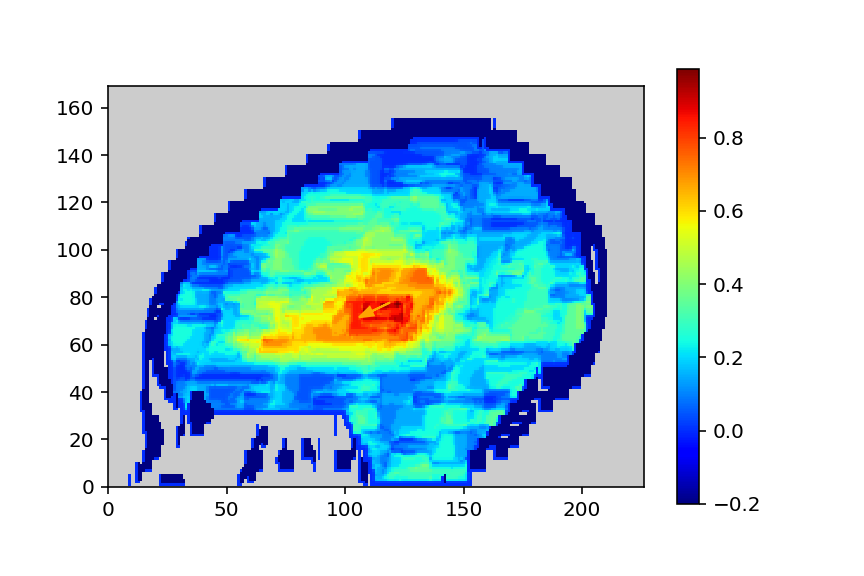

In [22]:
%matplotlib nbagg
fig, ax = plt.subplots()
lesion_contour[lesion_contour==0]=np.nan
palette = plt.cm.jet
palette.set_bad(alpha=0.2)
heatmap = ax.imshow(mps_contour.transpose(), cmap=palette)
# heatmap = ax.imshow(lesion_contour.transpose(), cmap=palette)
# heatmap = ax.imshow(Skull_Contour.transpose())

plt.ylim(0, Skull_Contour.shape[1])
plt.xlim (0,Skull_Contour.shape[0])
# ax.set_aspect(ConstPixelSpacing[2]/ConstPixelSpacing[1])
plt.colorbar(heatmap)
plt.show()

os.chdir(path)
plt.savefig('mps_contour.png')

# Metrics

In [54]:
from skimage import filters
import scipy.ndimage as ndi
from skimage.segmentation import find_boundaries as boundaries
import skimage

def region_parameter(region):
    #     Output the region parameters including centroid coordinate, 
    #     region area, length of major and minor axis
    labels = skimage.measure.label(region, connectivity=1)
    props = skimage.measure.regionprops(labels)
    v = [p.area for p in props]
    ind = np.argsort(v)
    # # From first to fourth biggest region
    #   determine whether the regions are connected or not
    n_regions = len(v)
    vcoords = props[ind[-1]].coords
    Area = v[ind[-1]]
    V_centroid = props[ind[-1]].centroid

    # The length of the major axis of the ellipse that has the same 
    # normalized second central moments as the region
    axis_major = props[ind[-1]].major_axis_length
    axis_minor = props[ind[-1]].minor_axis_length
    return n_regions,Area,V_centroid,axis_major,axis_minor

def average(xs):
    N = float(len(xs))
    return tuple(sum(col)/N for col in zip(*xs))

MPS = ww
# Region of relative MPS greater than 0.6
region06 = np.zeros(MPS.shape)
region06[MPS>0.6] = 1

# Region of relative MPS greater than 0
region0 = np.zeros(MPS.shape)
region0[MPS>0] = 1

# Region of relative MPS greater than 0.8
region08 = np.zeros(MPS.shape)
region08[MPS>0.8] = 1

# Region of relative MPS greater than 0.8
region04 = np.zeros(MPS.shape)
region04[MPS>0.4] = 1

n,Area0,Centroid0,axis_major0,axis_minor0 = region_parameter(region0)
n,Area4,Centroid4,axis_major4,axis_minor4 = region_parameter(region04)
n,Area6,Centroid6,axis_major6,axis_minor6 = region_parameter(region06)
n,Area8,Centroid8,axis_major8,axis_minor8 = region_parameter(region08)

maxMPS = np.where(ww==np.nanmax(ww))[0][0],np.where(ww==np.nanmax(ww))[1][0]



# Vectors pointing from centroid of brain to centroid of cross plane deviation
mps_centroid = average([Centroid4,Centroid6,Centroid8])

vec1 = np.subtract(mps_centroid,Centroid0)
# vec1 pointing tawards the centroid of midplane deviation
vec2 = np.subtract(maxMPS,Centroid0)
# vec2 pointing towards the max MPS deviation point


import matplotlib
x,y = Centroid0
dx,dy = vec1
wx,wy = vec2

matplotlib.pyplot.arrow(x, y, dx, dy,head_width=4,color = 'orange')


# Specify vec1 or vec2

/anaconda/envs/mic3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater
/anaconda/envs/mic3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in greater
/anaconda/envs/mic3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater
/anaconda/envs/mic3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in greater


<IPython.core.display.Javascript object>


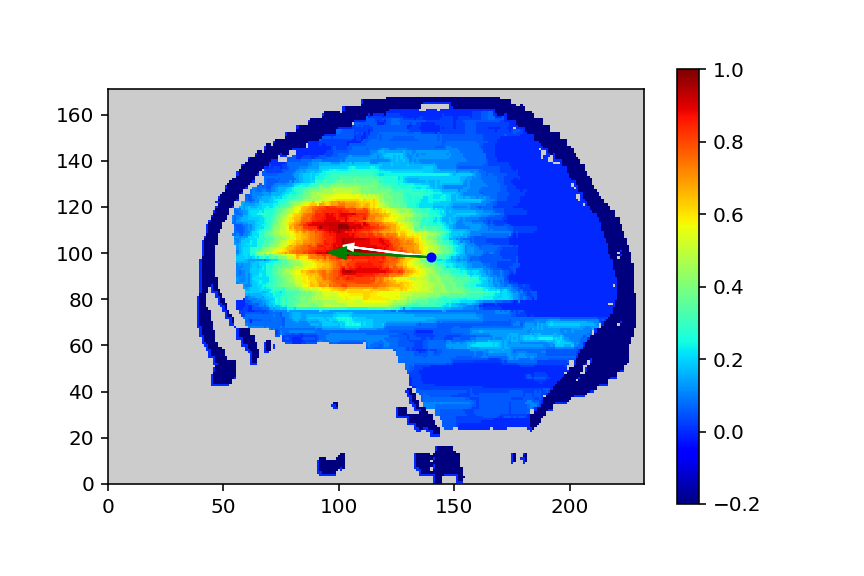

In [55]:
%matplotlib nbagg
fig, ax = plt.subplots()
palette = plt.cm.jet
palette.set_bad(alpha=0.2)
Skull_Contour[Skull_Contour==0]= np.nan
heatmap = ax.imshow(mps_contour.transpose(), cmap=palette)
# matplotlib.pyplot.arrow(x, y, dx, dy,head_width=4)
# matplotlib.pyplot.arrow(x, y, dx, dy,head_width=4)

matplotlib.pyplot.arrow(x, y, dx, dy,head_width=3,color = 'white')
# white towards centroid of MPS deviation
# green towards max MPS point
matplotlib.pyplot.arrow(x, y, wx, wy,head_width=5,color = 'green')


plt.plot([x], [y], marker='o', markersize=4, color="blue")

# heatmap = ax.imshow(lesion_contour.transpose(), cmap=palette)
# heatmap = ax.pcolor(brain_diff==0, cmap=plt.cm.winter)
plt.ylim(0, Skull_Contour.shape[1])
plt.xlim (0,Skull_Contour.shape[0])
# ax.set_aspect(ConstPixelSpacing[2]/ConstPixelSpacing[1])
plt.colorbar(heatmap)
plt.show()
# plt.ion()

In [390]:
os.chdir(path)
plt.savefig('mps_vecs.png')

In [391]:
vec1, vec2

(array([-22.20477388,  -3.6057751 ]), array([-10.50398724,  -5.92640693]))

In [58]:
# axis_pair8,axis_pair6,axis_pair4,axis_pair0 = [],[],[],[]
# area8,area6,area4,area0 =  [],[],[],[]
# maxMPS_list, centroidMPS_list,centroid_Brain = [], [],[]
# vec1_list, vec2_list = [], []
# volume = []

volume.append((np.nansum(MPS_metrix)))
vec1_list.append((vec1))
vec2_list.append((vec2))
centroid_Brain.append((Centroid0))
centroidMPS_list.append((mps_centroid))
maxMPS_list.append((maxMPS))
area8.append((Area8))
area6.append((Area6))
area4.append((Area4))
area0.append((Area0))

axis_pair8.append((axis_major8,axis_minor8))
axis_pair6.append((axis_major6,axis_minor6))
axis_pair4.append((axis_major4,axis_minor4))
axis_pair0.append((axis_major0,axis_minor0))



In [59]:
output = {'Area80%': area8, 'Area60%': area6,'Area40%':area4, 'Area_crossbrain':area0,
         'axis_80%':axis_pair8,'axis_60%':axis_pair6,'axis_40%':axis_pair4,'axis_0%':axis_pair0,
          'maxMPS_coord':maxMPS_list, 'centroidMPS_coord':centroidMPS_list,'centroid_Brain_coord':centroid_Brain,
          'mps_centroid_vec':vec1_list, 'max_mps_vec':vec2_list,'mps_volume':volume
         }
output

{'Area40%': [3033],
 'Area60%': [1778],
 'Area80%': [774],
 'Area_crossbrain': [13710],
 'axis_0%': [(157.17365622970493, 116.0480431874023)],
 'axis_40%': [(74.89924388027067, 52.51955320256318)],
 'axis_60%': [(56.80804362303716, 40.560577373126755)],
 'axis_80%': [(40.645847135641425, 25.86004816009181)],
 'centroidMPS_coord': [(106.1889327011268, 102.55717613628524)],
 'centroid_Brain_coord': [(139.67658643326038, 98.285412107950407)],
 'maxMPS_coord': [(103, 100)],
 'max_mps_vec': [array([-36.67658643,   1.71458789])],
 'mps_centroid_vec': [array([-33.48765373,   4.27176403])],
 'mps_volume': [60699.873333333329]}

In [401]:
import pandas as pd
longlist = pd.DataFrame(data = output)

<IPython.core.display.Javascript object>


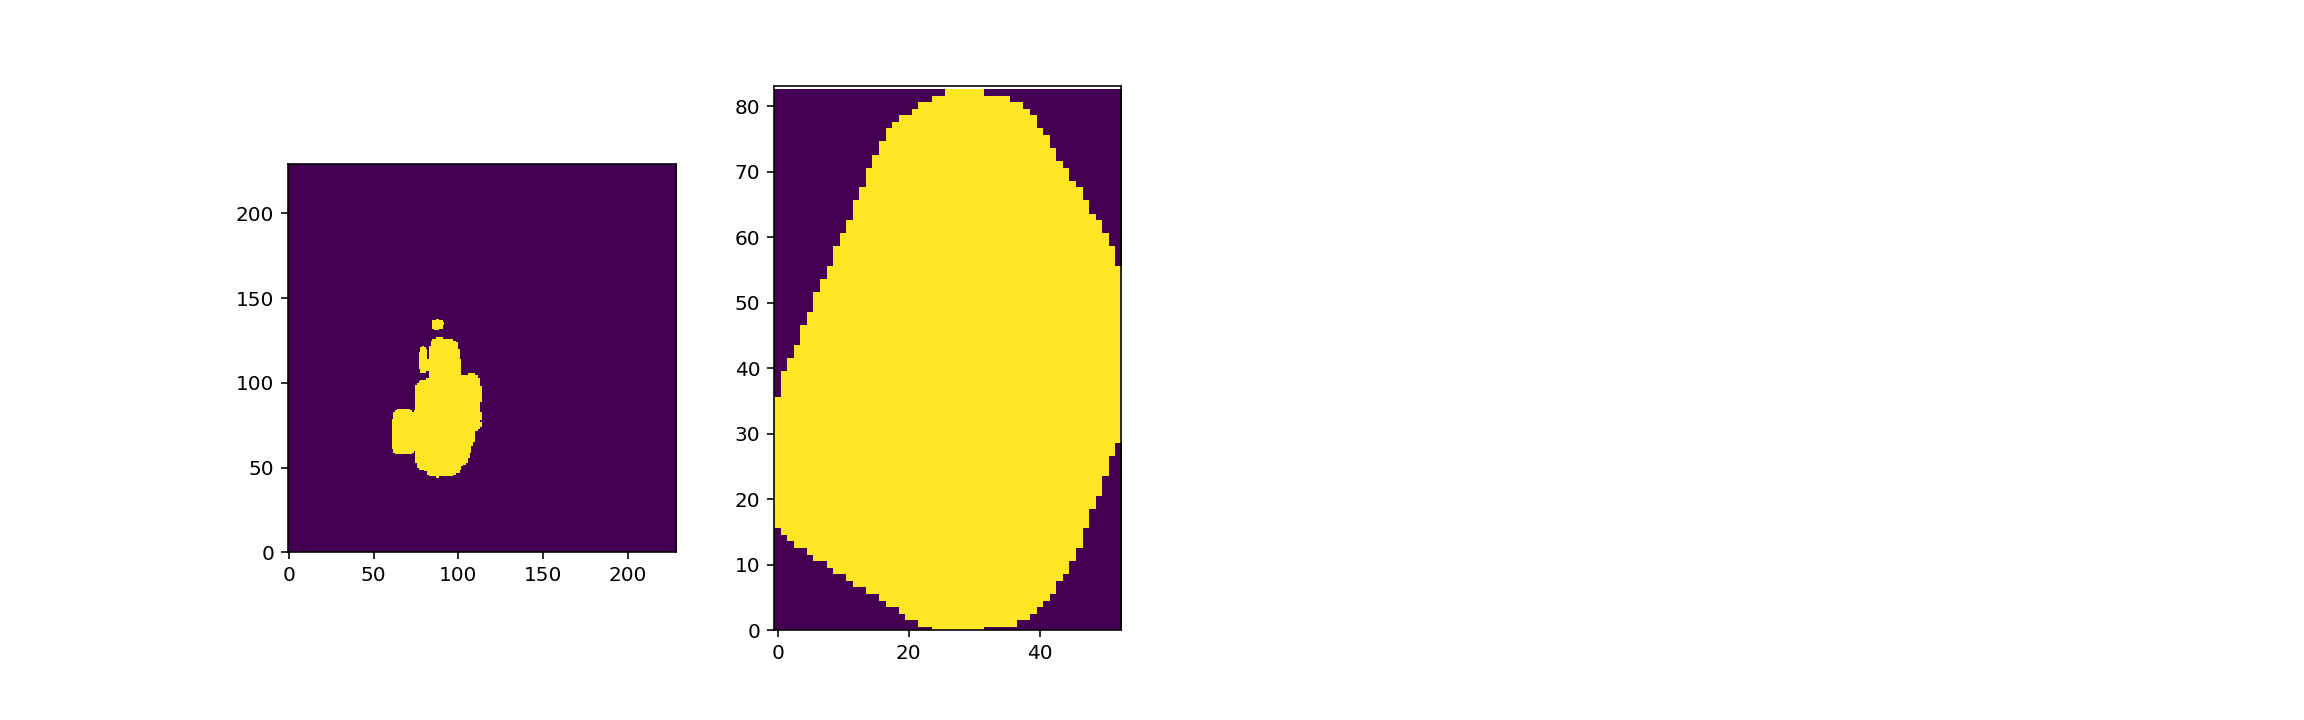

In [441]:
ROI = region04
labels = skimage.measure.label(ROI, connectivity=1)
props = skimage.measure.regionprops(labels)
v = [p.area for p in props]
ind = np.argsort(v)
# # From first to fourth biggest region
vcoords = props[ind[-1]].coords
Area = v[ind[-1]]
V_centroid = props[ind[-1]].centroid

# The length of the major axis of the ellipse that has the same 
# normalized second central moments as the region
axis_major = props[ind[-1]].major_axis_length
axis_minor = props[ind[-1]].minor_axis_length
convex = props[ind[-1]].convex_image

plt.figure(figsize=(16,5))
plt.subplot(141)
plt.imshow(ROI)
plt.ylim(0, ROI.shape[0])
plt.subplot(142)
plt.ylim(0, convex.shape[0])
plt.imshow(convex)

In [399]:
# attempts to interpolate the hole in the middle, turns out not functioning probably because the whole is two big
# import scipy
# coords = (np.array(ylist),np.array(zlist))
# y = np.nonzero(MPS_metrix_normalized)[0]
# z = np.nonzero(MPS_metrix_normalized)[1]
# gy = np.arange(min(y),max(y)+1)
# gz = np.arange(min(z),max(z)+1)

# ylist = []
# zlist = []

# for i in gy:
#     for j in gz:
#         ylist.append((i))
#         zlist.append((j))

# dis_linear = scipy.interpolate.griddata(coords,MPS_metrix_normalized[coords],coords,method='nearest')
# dis_linear == MPS_metrix_normalized[coords]
# MPS_metrix_normalized[coords] = dis_linear

In [26]:
import pandas as pd
os.chdir('/Volumes/FAIR/DC-Image-Analysis/DC-project-master/cleancode/NewMidplane')

MPS_metrix = pd.read_csv('MPS_metrix.csv')

In [27]:
MPS_metrix

,Unnamed: 0,Area80%,Area60%,Area40%,Area_crossbrain,axis_80%,axis_60%,axis_40%,axis_0%,maxMPS_coord,centroidMPS_coord,centroid_Brain_coord,mps_centroid_vec,max_mps_vec,mps_volume
0,0,184,771,1838,14283,"(26.466918571453427, 10.82985573344769)","(42.303929939449844, 25.973781113519127)","(63.460812665461305, 41.86303166686871)","(165.35794680372015, 121.71243104929258)","(65, 87)","(73.678862797293377, 87.884761135438225)","(118.1120912973465, 78.667926906112157)",[-44.4332285 9.21683423],[-53.1120913 8.33207309],13751.275238
1,1,795,2015,3158,14040,"(39.95757209600839, 26.469830738636006)","(66.58799679934322, 40.35229280770641)","(82.7808658781798, 49.68349549389655)","(155.01747538611767, 119.49050455472127)","(90, 79)","(89.730863936530298, 72.852327319053146)","(109.83475783475784, 68.01217948717948)",[-20.1038939 4.84014783],[-19.83475783 10.98782051],49552.136414
2,2,606,1565,2764,18503,"(30.42464974007875, 28.203399368022254)","(57.18794654478523, 36.1918399593306)","(73.07533917534381, 49.84688044920632)","(178.28753573423043, 139.00963184785084)","(124, 111)","(123.98174480246303, 116.23921693589257)","(144.1642436361671, 115.37685780684214)",[-20.18249883 0.86235913],[-20.16424364 -4.37685781],71572.109881
3,3,64,741,2362,18212,"(13.556760830278579, 8.343420958493253)","(43.25089195882912, 37.59598361894626)","(65.3174301066043, 53.84800256313104)","(183.4399251732889, 131.24083316323612)","(148, 167)","(142.97710186291383, 161.4381931243889)","(153.04700197671863, 137.34674939600262)",[-10.06990011 24.09144373],[ -5.04700198 29.6532506 ],15906.198016
4,4,106,832,2097,15220,"(30.994211301486736, 5.014718600743625)","(51.060810402728464, 23.670408369159407)","(64.36163190381382, 45.143819191645235)","(166.57328639729528, 122.75359870142958)","(100, 119)","(104.86846965690268, 116.70597846559083)","(122.69520367936926, 100.44579500657031)",[-17.82673402 16.26018346],[-22.69520368 18.55420499],22928.968968
5,5,391,2033,4004,18733,"(61.27781597875503, 8.620575424305239)","(77.0030097230205, 38.30915436981391)","(100.65589035734793, 58.75990579850087)","(184.1402406764204, 137.51323478794717)","(52, 112)","(80.084145322821925, 114.75495915543884)","(115.4505952063204, 96.298777558319543)",[-35.36644988 18.4561816 ],[-63.45059521 15.70122244],23196.283333
6,6,519,1804,3422,17837,"(41.719418080833734, 16.50538868682253)","(73.27448640818878, 32.21944093172282)","(96.77620583135932, 45.639307150236306)","(186.34072261282498, 125.56087228296599)","(150, 92)","(151.6764402820115, 88.171299521530173)","(174.25918035544095, 89.666984358356231)",[-22.58274007 -1.49568484],[-24.25918036 2.33301564],85444.793319
7,7,732,2482,3711,18852,"(42.46326480536274, 23.335186753260142)","(71.31534617167048, 44.871930946436144)","(85.6195890814184, 55.54067258407537)","(189.71136539087303, 131.26263367687773)","(123, 103)","(130.4704606636291, 94.822959487303834)","(105.46297475068958, 93.461542541905374)","(-25.007485912939515, 1.3614169453984601)","(-17.537025249310418, 9.5384574580946264)",118899.183317
8,8,556,2089,3823,14145,"(30.86353246257973, 28.17318169720198)","(63.04908478983055, 45.136260916026686)","(80.91988198918557, 63.85949355600854)","(153.1822064481501, 123.37843099353906)","(111, 90)","(112.71366549785488, 90.49519972689717)","(130.49939908094734, 85.542806645457759)",[-17.78573358 4.95239308],[-19.49939908 4.45719335],62236.049394
9,9,330,1089,2164,15742,"(34.81839348790727, 16.15821420540798)","(48.93072467294395, 32.75807224226542)","(69.68536177497269, 44.522003236142695)","(161.0201841107354, 128.97321735665815)","(107, 80)","(115.48503344088959, 77.304727949409525)","(135.48456358785415, 73.013594206581118)",[-19.99953015 4.29113374],[-28.48456359 6.98640579],38809.897431


In [30]:
longlist = MPS_metrix
for i in longlist['mps_centroid_vec']:
    print(i)

[-44.4332285    9.21683423]
[-20.1038939    4.84014783]
[-20.18249883   0.86235913]
[-10.06990011  24.09144373]
[-17.82673402  16.26018346]
[-35.36644988  18.4561816 ]
[-22.58274007  -1.49568484]
(-25.007485912939515, 1.3614169453984601)
[-17.78573358   4.95239308]
[-19.99953015   4.29113374]
[-18.21343931   3.83859707]
[-7.45982549 -3.56035831]
[-22.20477388  -3.6057751 ]


In [33]:
%matplotlib nbagg
fig, ax = plt.subplots()
palette = plt.cm.jet
palette.set_bad(alpha=0.2)
Skull_Contour[Skull_Contour==0]= np.nan
heatmap = ax.imshow(Skull_Contour.transpose(), cmap=palette)
# matplotlib.pyplot.arrow(x, y, dx, dy,head_width=4)
# matplotlib.pyplot.arrow(x, y, dx, dy,head_width=4)

for i in longlist['mps_centroid_vec']:
    matplotlib.pyplot.arrow(x, y, i[0], i[1],head_width=3,color = 'red')
    plt.plot([x], [y], marker='o', markersize=4, color="blue")
# white towards centroid of MPS deviation
# green towards max MPS point
# matplotlib.pyplot.arrow(x, y, wx, wy,head_width=5,color = 'green')


plt.plot([x], [y], marker='o', markersize=4, color="blue")

# heatmap = ax.imshow(lesion_contour.transpose(), cmap=palette)
# heatmap = ax.pcolor(brain_diff==0, cmap=plt.cm.winter)
plt.ylim(0, Skull_Contour.shape[1])
plt.xlim (0,Skull_Contour.shape[0])
# ax.set_aspect(ConstPixelSpacing[2]/ConstPixelSpacing[1])
plt.colorbar(heatmap)
plt.show()
# plt.ion()

<IPython.core.display.Javascript object>

TypeError: ufunc 'hypot' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [47]:
import scipy
import scipy.io
os.chdir(path)
scipy.io.savemat('Contours.mat',{'Skull_contour':Skull_Contour,'lesion_contour':lesion_contour})

In [14]:
os.chdir(path)
plt.savefig('lesion_heatmap.png')

NameError: name 'path' is not defined

In [296]:
Skull_Contour.shape

(239, 190)

In [306]:
Skull_Contour[Skull_Contour!=]

array([ nan,  nan,  nan, ...,  nan,  nan,  nan])

In [312]:
np.mean(np.nonzero(Skull_Contour),1)

array([ 119. ,   94.5])

In [7]:
import scipy
import scipy.io

MPS_array = scipy.io.loadmat('/Volumes/FAIR/Eric_Midlinedeliniation/Self-MPS/SDH16-2/MPS1.mat')['mm']

In [12]:
y = MPS_array[0]
z = MPS_array[1]
dis = MPS_array[2]